We scanned 10 fishes for Carolina, let's preview them.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook
import scipy.signal

C:\Users\haberthu\Miniconda3\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:61463/status"


In [92]:
# # https://stackoverflow.com/a/62242245/323100
# import warnings
# warnings.filterwarnings('ignore')

In [93]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [94]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [95]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [96]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\Zebrafish_Carolina_Muscles


In [97]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [98]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [99]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\Zebrafish-Carolina\Output\19de54d


In [100]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [101]:
# Get *all* log files in the root folder
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'),
                                               recursive=True))]

In [102]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [103]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [104]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 10 subfolders in D:\Results\Zebrafish_Carolina_Muscles


In [105]:
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]

In [106]:
def whichexperiment(i):
    '''Categorize into 'WT' and 'KO' '''
    if 'ko' in i:
        return 'KO'
    if 'wt' in i:
        return 'WT'

In [107]:
Data['Experiment'] = [whichexperiment(f) for f in Data['Sample']]

In [108]:
def whichfish(i):
    '''Give each fish a number '''
    return int(i[2:])

In [109]:
Data['Fish'] = [whichfish(f) for f in Data['Sample']]

In [110]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [111]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    pixelsize = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [112]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [227]:
# Load rechunked reconstructions
Data['OutputNameRechunk'] = [os.path.join(os.path.dirname(f),
                                      fish + '_rechunk.zarr') for f, fish in zip(Data['Folder'],
                                                                             Data['Sample'])]

In [228]:
# Load the (rechunked) reconstructions from zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRechunk']]

In [115]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [116]:
# The three cardinal directions
directions = ['Transversal',
              'Coronal',
              'Sagittal']

In [216]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.Middle.%s.png' % (row['Sample'],
                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Transversal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [217]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=-d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [218]:
# Transpose images, so the fishes are horizontal...
for c, row in notebook.tqdm(Data.iterrows(), desc='Transpose Sagittal and coronal images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions[1:]),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions[1:])):
        Data.at[c,'Mid_' + direction] = Data.at[c,'MIP_' + direction].transpose()
        Data.at[c,'MIP_' + direction] = Data.at[c,'MIP_' + direction].transpose()

In [210]:
# Detect 'center' of the fishes
# For this we select the sagittal center between the otholiths

In [211]:
def otolither(img, sigma=5, threshold=180, verbose=False):
    '''
    Function to detect the otoliths in the axial MIPs.
    We simply look for peaks in the gray values :)
    '''
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Detect peaks in smoothed image, in x- and y-direction
    x = numpy.mean(smoothed>threshold, axis=0)
    y = numpy.mean(smoothed>threshold, axis=1)
    peaksx, _ = scipy.signal.find_peaks(x)
    peaksy, _ = scipy.signal.find_peaks(y)
    if verbose:
        plt.imshow(img)
        plt.imshow(numpy.ma.masked_less(img, threshold), cmap='viridis', alpha=0.618)            
        for p in peaksx:
            plt.axvline(p, alpha=0.5)
        for p in peaksy:
                plt.axhline(p, alpha=0.5)
        plt.axvline(numpy.mean(peaksx))
        plt.axhline(numpy.mean(peaksy))
        plt.show()
    return([peaksx.tolist(), peaksy.tolist()])

In [213]:
# Try to estimate the otholith position
# We use this later for cropping the head off
for d, direction in enumerate(directions):
    Data['Otholith_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='Find Otolith position', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        Data.at[c,'Otholith_' + direction] = otolither(row['MIP_' + direction], threshold=180, verbose=False)

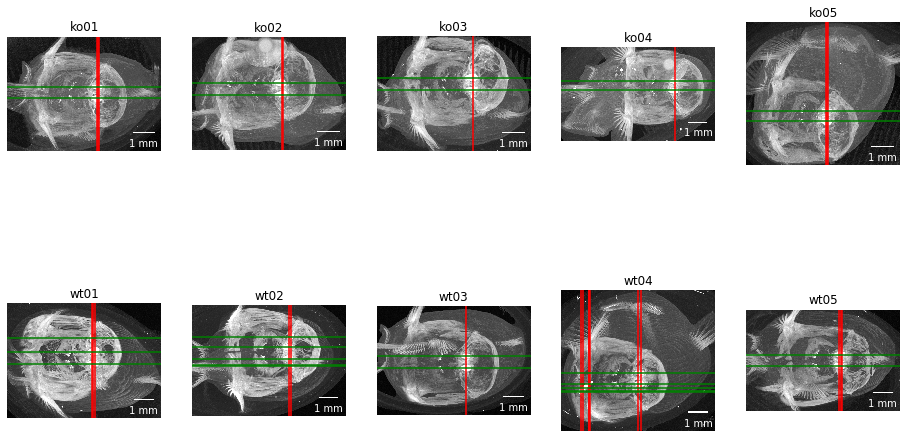

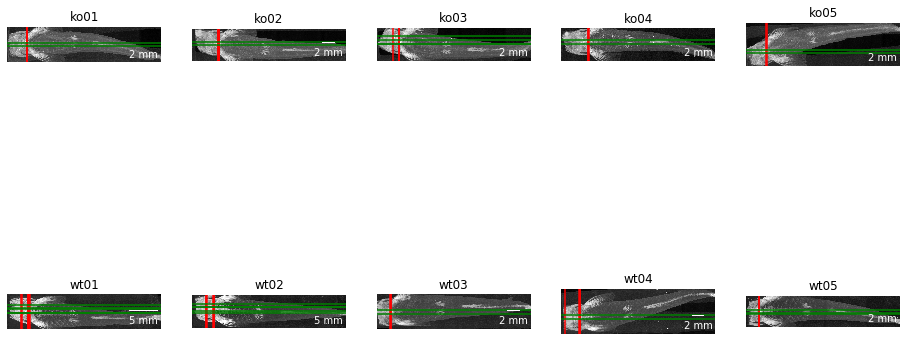

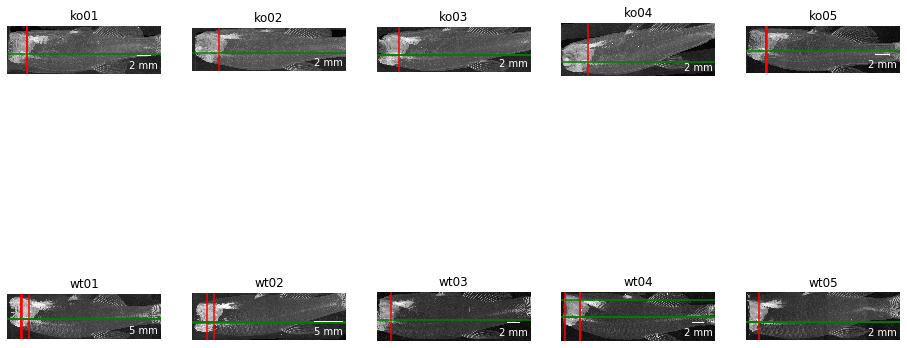

In [219]:
# Preview what we found
for d, direction in enumerate(directions):
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction], vmax=150)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title(row['Sample'])
        plt.axis('off')
        for i in row['Otholith_' + direction][0]:
            plt.axvline(i, c='r')
        for i in row['Otholith_' + direction][1]:
            plt.axhline(i, c='g')    
    plt.show()

In [123]:
import dask_image.imread
import dask_image.ndfilters

image = Reconstructions[3]
locthresh = dask_image.ndfilters.threshold_local(image, block_size=20, offset=10)

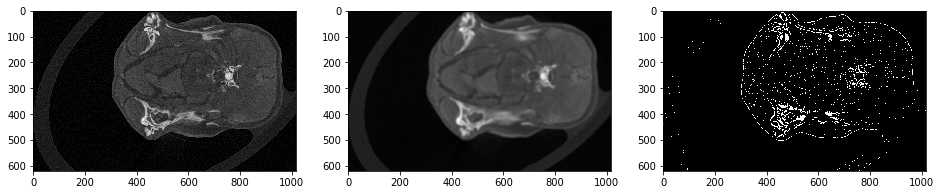

In [124]:
slice = 555
plt.subplot(131)
plt.imshow(image[slice])
plt.subplot(132)
plt.imshow(locthresh[slice])
plt.subplot(133)
plt.imshow(image[slice]<locthresh[slice])

In [220]:
def croptop(whichone, verbose=False):
    '''Function to crop off top of the head, based on location of otolith'''
    crop = numpy.median(Data.Otholith_Coronal[whichone][1] + Data.Otholith_Sagittal[whichone][1])
    if verbose:
        plt.subplot(211)
        plt.imshow(Data['MIP_Sagittal'][whichone].transpose(), vmax=180)
        plt.plot(Data['MIP_Sagittal'][whichone].transpose().max(axis=0))
        for i in Data.Otholith_Sagittal[whichone][1]:
            plt.axvline(i)
        plt.axvline(crop, c='r')
        plt.subplot(212)
        plt.imshow( Data['MIP_Coronal'][whichone].transpose(), vmax=180)
        plt.plot(Data['MIP_Coronal'][whichone].transpose().max(axis=0))
        for i in Data.Otholith_Coronal[whichone][1]:
            plt.axvline(i)
        plt.axvline(crop, c='r')
        plt.show()
    return(int(crop))

In [234]:
# Calculate where we crop the head off and do it
Data['HeadCrop'] = [croptop(i) for i in range(len(Data))]
Reconstructions = [rec[row.HeadCrop+100:] for rec in Reconstructions]

In [238]:
def tailcutter(img, sigma=5, threshold=180, verbose=False):
    '''
    Function to detect where the tail is.
    We simply look for peaks in the gray values :)
    '''
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Detect peaks in smoothed image, in x- and y-direction
    x = numpy.mean(smoothed>threshold, axis=0)
    y = numpy.mean(smoothed>threshold, axis=1)
    peaksx, _ = scipy.signal.find_peaks(x)
    peaksy, _ = scipy.signal.find_peaks(y)
    if verbose:
        plt.imshow(img, vmax=100)
        plt.imshow(numpy.ma.masked_less(img, threshold), cmap='viridis', alpha=0.618)            
        for p in peaksx:
            plt.axvline(p, alpha=0.5)
        for p in peaksy:
                plt.axhline(p, alpha=0.5)
        plt.axvline(numpy.mean(peaksx))
        plt.axhline(numpy.mean(peaksy))
        plt.show()
    return([peaksx.tolist(), peaksy.tolist()])

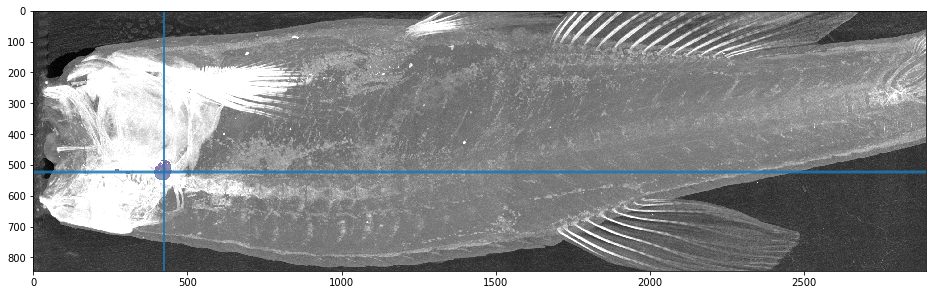

[[425], [521, 525]]

In [241]:
tailcutter(Data.Mid_Sagittal[2], verbose=True)